# Probabilidad de Adición

(Escribir conexto****)

#### Librerias

In [3]:
# Importacion de librerias
# Conexión a la base de datos
# ==========================================
import os
import sys
import pathlib

sys.path.append(
    os.path.join(pathlib.Path(os.getcwd()).parent)
)

from utils.bq_conn import bq_conn_file

bq_client = bq_conn_file(project_id="dsa-miad-365616")

# Tratamiento de datos
# ==========================================
import pandas as pd
import numpy as np
from datetime import datetime

# Graficas
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import seaborn as sns

# Modelos ML
# ==========================================
from sklearn import preprocessing
#from pycaret.clustering import *
#from pycaret.classification import *
#from pycaret.regression import *

Consulta SQL.

In [4]:
query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''

In [5]:
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset es de: {secop_I.shape[0]}\nEl número de columnas del dataset es de: {secop_I.shape[1]}")
secop_I.head(5)

El número de filas del dataset es de: 26553
El número de columnas del dataset es de: 38


,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,...,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,...,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,...,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,...,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,...,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,...,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


#### Diagrama de correlación

En primer lugar queremos entender si la probabilidad de adición depende de ciertas variables categoricas tales como el departamento, tipo de contrato, estado de proceso, grupo al que pertence el gasto entre otras variables. Para ello, se realizará un diagrama de correlación para confirmar a través de este tipo de análisis si esto relamente es así.

Antes de su aplicación, se deberá transformar dichas variables de tipo string a númericas las cuales permita identificar las posibles clasificaciones de cada una de estas variables. 

In [6]:
secopI_filter = secop_I.copy()

# transformación de la variables
label_encoder = preprocessing.LabelEncoder()

# modalidad de contratación
secopI_filter['modalidad_de_contratacion']= label_encoder.fit_transform(secopI_filter['modalidad_de_contratacion'])

# estado de proceso
secopI_filter['estado_del_proceso']= label_encoder.fit_transform(secopI_filter['estado_del_proceso'])

# objeto a contratar
secopI_filter['id_objeto_a_contratar']= label_encoder.fit_transform(secopI_filter['id_objeto_a_contratar'])

# tipo de contrato
secopI_filter['tipo_de_contrato']= label_encoder.fit_transform(secopI_filter['tipo_de_contrato'])

# municipio
secopI_filter['municipios_ejecucion_']= label_encoder.fit_transform(secopI_filter['municipios_ejecucion_'])

# departamento
secopI_filter['departamento_ejecucion']= label_encoder.fit_transform(secopI_filter['departamento_ejecucion'])

# grupo
secopI_filter['nombre_grupo']= label_encoder.fit_transform(secopI_filter['nombre_grupo'])

# familia
secopI_filter['nombre_familia']= label_encoder.fit_transform(secopI_filter['nombre_familia'])

# clase
secopI_filter['nombre_clase']= label_encoder.fit_transform(secopI_filter['nombre_clase'])

# identificacion del contratista
secopI_filter['identificacion_del_contratista']= label_encoder.fit_transform(secopI_filter['identificacion_del_contratista'])

In [7]:
secopI_filter = secopI_filter.filter(items=['con_adicion_pptal', 'modalidad_de_contratacion', 'estado_del_proceso',
                                            'id_objeto_a_contratar', 'tipo_de_contrato', 'municipios_ejecucion_',
                                            'departamento_ejecucion', 'nombre_grupo', 'nombre_familia', 'nombre_clase', 
                                            'identificacion_del_contratista'])
secopI_filter.head(5)

,con_adicion_pptal,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,tipo_de_contrato,municipios_ejecucion_,departamento_ejecucion,nombre_grupo,nombre_familia,nombre_clase,identificacion_del_contratista
0,0,2,2,28,10,67,15,4,202,383,6559
1,0,1,2,31,9,29,4,4,231,938,4505
2,0,1,2,33,9,29,4,4,177,697,4267
3,0,1,5,38,9,29,4,5,256,760,4518
4,0,0,2,39,6,29,4,5,258,815,3988


<Axes: >

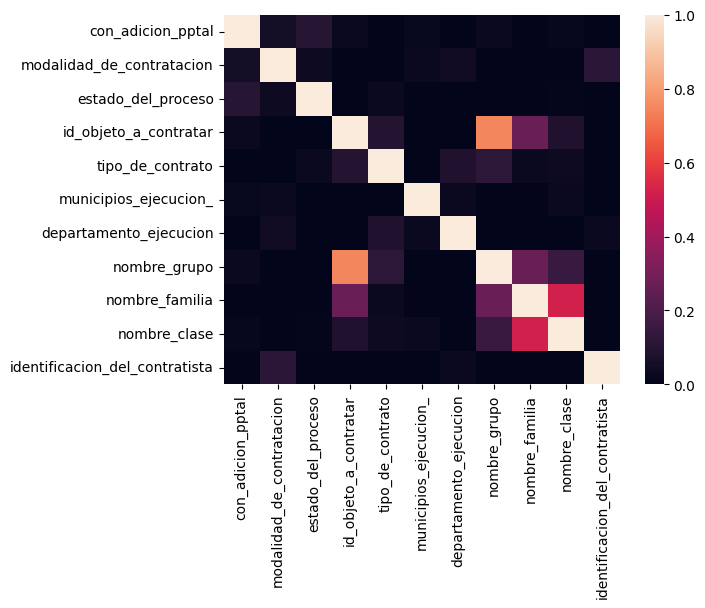

In [8]:
corr = secopI_filter.dropna().corr()
sns.heatmap(corr, vmin=0, vmax=1)

Del anterior correlograma, se puede inferir que hay una correlación fuerte entre las variables objeto a contratar versus el grupo. Asimismo, esta tiene una correlación importante con la familia y como podría esperarse la familia se encuentra altamente correlacionada con la clase. Esto se debe a que la familia y clase son sub-conjuntos de la variable grupo.

#### Distribución de las variables

In [9]:
secopI_sin_adicion = secopI_filter.filter(items=['modalidad_de_contratacion', 'estado_del_proceso',
                                            'id_objeto_a_contratar', 'tipo_de_contrato', 'municipios_ejecucion_',
                                            'departamento_ejecucion', 'nombre_grupo', 'nombre_familia', 'nombre_clase', 
                                            'identificacion_del_contratista'])
secopI_sin_adicion.head(5)

,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,tipo_de_contrato,municipios_ejecucion_,departamento_ejecucion,nombre_grupo,nombre_familia,nombre_clase,identificacion_del_contratista
0,2,2,28,10,67,15,4,202,383,6559
1,1,2,31,9,29,4,4,231,938,4505
2,1,2,33,9,29,4,4,177,697,4267
3,1,5,38,9,29,4,5,256,760,4518
4,0,2,39,6,29,4,5,258,815,3988


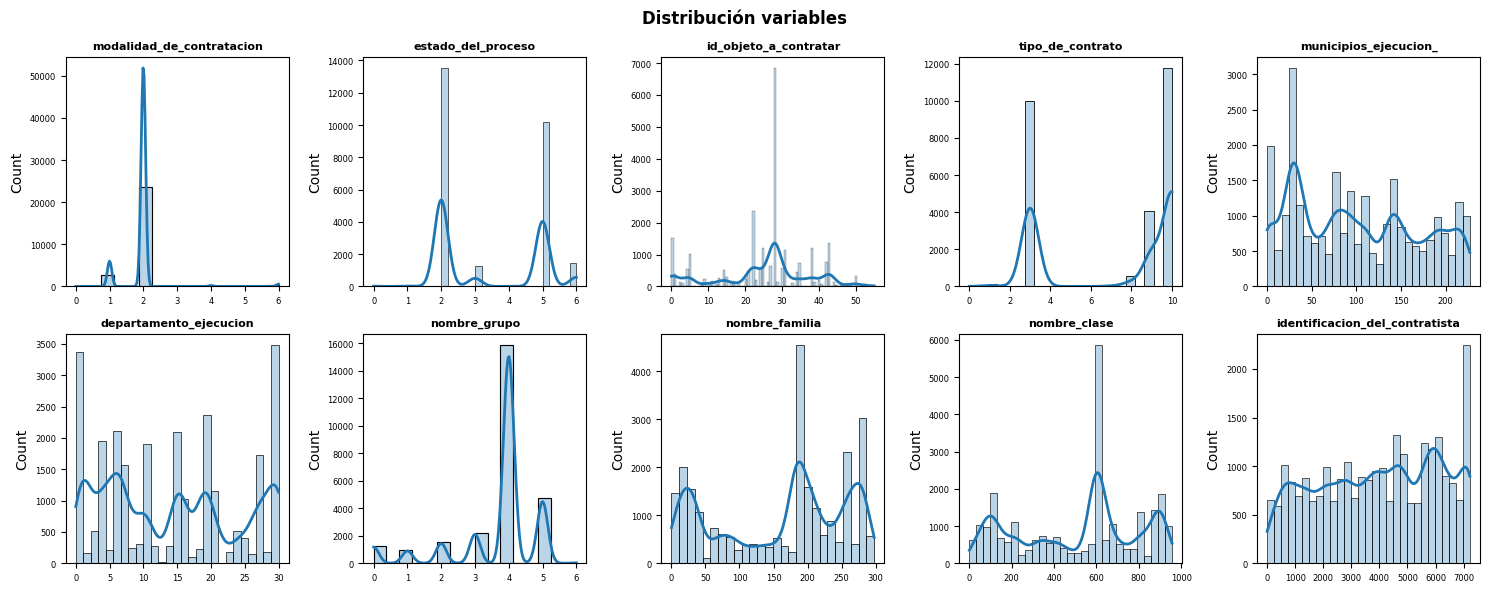

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flat
columnas_numeric = secopI_sin_adicion.select_dtypes(include=['float64', 'int']).columns

for i, column in enumerate(columnas_numeric):
    sns.histplot(
        data    = secopI_sin_adicion,
        x       = column,
        stat    = "count",
        kde     = True,
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(column, fontsize=8, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables', fontsize=12, fontweight="bold");

#### Conjunto de datos en *train* y *test*

Se particiona el conjunto de datos dos subconjuntos de datos, *train* que es el conjunto de datos utilizados para entrenar los modelos el cual representa el 80% de los datos totales y *test* para comprobar el rendimiento de los modelos que representa el 20% restante.  

In [11]:
# conjunto de datos train
train_datos = secopI_filter.sample(frac=0.8, random_state=0)
train_datos.head(5)

,con_adicion_pptal,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,tipo_de_contrato,municipios_ejecucion_,departamento_ejecucion,nombre_grupo,nombre_familia,nombre_clase,identificacion_del_contratista
23698,0,2,3,25,3,41,5,4,277,331,7215
19086,0,2,5,28,10,60,6,4,185,598,6031
20272,0,2,5,15,10,156,6,0,185,598,1366
992,0,2,6,0,3,109,7,2,37,59,4032
3302,0,2,5,22,3,97,1,4,279,886,6662


In [12]:
# conjunto de datos test
test_datos = secopI_filter.drop(train_datos.index)
test_datos.head(5)

,con_adicion_pptal,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,tipo_de_contrato,municipios_ejecucion_,departamento_ejecucion,nombre_grupo,nombre_familia,nombre_clase,identificacion_del_contratista
10,0,1,5,43,9,29,4,5,246,376,2373
13,0,1,2,43,9,73,15,5,262,217,1715
19,0,1,2,43,9,73,15,5,262,217,2877
28,0,1,2,43,9,73,15,5,262,217,2994
40,0,1,2,43,9,73,15,5,262,217,7193


In [13]:
train_datos.reset_index(inplace=True, drop=True)
test_datos.reset_index(inplace=True, drop=True)
print('Datos para el modelo: ' + str(train_datos.shape))
print('Datos para las predicciones: ' + str(test_datos.shape))

Datos para el modelo: (21242, 11)
Datos para las predicciones: (5311, 11)


#### Tipo de modelos
*(Tomado de la documentacion de PyCaret)*

Paso seguido se define el entorno de PyCaret con los datos de entrenamiento, esto hará que cada vez que se llame a un modelo a entrenar se escojan dichos datos para entrenar. Además este proceso también preprocesa los datos automáticamente de manera que sea más fácil aplicar los modelos estadísticos. Asimismo, se valida que tipo de modelos ofrece la libreria PyCaret

In [14]:
from pycaret.clustering import *
model_clustering = setup(data=secopI_filter, session_id=123)
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch


Se agrega el parametro *fix_imbalance* que balance la varaible de interés.

In [15]:
from pycaret.classification import *
model_classification = setup(data=train_datos, target='con_adicion_pptal', session_id=123, fix_imbalance=True)
models()

,Description,Value
0,Session id,123
1,Target,con_adicion_pptal
2,Target type,Binary
3,Original data shape,"(21242, 11)"
4,Transformed data shape,"(32973, 11)"
5,Transformed train set shape,"(26600, 11)"
6,Transformed test set shape,"(6373, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [16]:
from pycaret.regression import *
model_regression = setup(data=secopI_filter, target='con_adicion_pptal', session_id=123)
models()

,Description,Value
0,Session id,123
1,Target,con_adicion_pptal
2,Target type,Regression
3,Original data shape,"(26553, 11)"
4,Transformed data shape,"(26553, 11)"
5,Transformed train set shape,"(18587, 11)"
6,Transformed test set shape,"(7966, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


#### Implementacion de los modelos

Se aplicarán los siguientes modelos:

1. lr --> Logistic Regression.
2. nb --> Naive Bayes.
3. lda --> Linear Discriminant Analysis.
4. qda --> Quadratic Discriminant Analysis.
5. gpc --> Gaussian Process Classifier.

In [27]:
# 1. train logistic regression
from pycaret.classification import *
lr_classification = setup(data=train_datos, target='con_adicion_pptal', session_id=123, fix_imbalance=True)
lr_adicion = create_model('lr')

,Description,Value
0,Session id,123
1,Target,con_adicion_pptal
2,Target type,Binary
3,Original data shape,"(21242, 11)"
4,Transformed data shape,"(32973, 11)"
5,Transformed train set shape,"(26600, 11)"
6,Transformed test set shape,"(6373, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:17:51
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5414,0.6135,0.6752,0.1438,0.2371,0.0763,0.1234
1,0.5447,0.6164,0.6497,0.1409,0.2316,0.0702,0.1119
2,0.5447,0.6319,0.6688,0.1438,0.2368,0.0762,0.1222
3,0.5783,0.6213,0.6051,0.1439,0.2326,0.0747,0.1115
4,0.5851,0.6677,0.6624,0.1557,0.2521,0.0979,0.1473
5,0.5535,0.6006,0.6115,0.1373,0.2243,0.0627,0.0973
6,0.5562,0.6156,0.6051,0.1371,0.2235,0.0621,0.0958
7,0.5541,0.6133,0.6369,0.1416,0.2317,0.0713,0.1116
8,0.5958,0.6484,0.7070,0.1667,0.2697,0.1192,0.1790


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [28]:
# 2. train naive bayes
from pycaret.classification import *
nb_model = setup(data=train_datos, target='con_adicion_pptal', session_id=123, fix_imbalance=True)
nb_adicion = create_model('nb')

,Description,Value
0,Session id,123
1,Target,con_adicion_pptal
2,Target type,Binary
3,Original data shape,"(21242, 11)"
4,Transformed data shape,"(32973, 11)"
5,Transformed train set shape,"(26600, 11)"
6,Transformed test set shape,"(6373, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:18:04
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5790,0.5936,0.5796,0.1398,0.2252,0.0664,0.0982
1,0.5622,0.5786,0.5732,0.1335,0.2166,0.0547,0.0828
2,0.5817,0.6272,0.5732,0.1395,0.2244,0.0658,0.0967
3,0.5837,0.6160,0.5669,0.1391,0.2233,0.0648,0.0947
4,0.5898,0.6450,0.6178,0.1499,0.2413,0.0860,0.1266
5,0.6120,0.6310,0.5605,0.1477,0.2337,0.0800,0.1120
6,0.5777,0.6044,0.5541,0.1349,0.2170,0.0568,0.0835
7,0.6100,0.6084,0.5287,0.1409,0.2225,0.0670,0.0931
8,0.5972,0.6205,0.6306,0.1547,0.2484,0.0950,0.1389


Processing:   0%|          | 0/4 [00:00<?, ?it/s]